# Student Project - Machine Learning for Renewable Energy Systems
## Coding Track: Forecasting Building Energy Data

### Task: Predict demand of the next step, next day and next week of at least one building per category.



This notebook was created as project in the course of the seminar [Machine Learning for Renewable Energy Systems](https://www.mlsustainableenergy.com/teaching/machine-learning-for-renewable-energy-systems/) in the reserach group [
Machine Learning in Sustainable Energy Systems](https://www.mlsustainableenergy.com/) at the University of Tübingen. <br> 
The code and the forecasting has been carried out in this jupyter notebook and is the work of 

    Markus Deppner   4106780   markus.deppner@student.uni-tuebingen.de
    
This project works with data from ["The Building Data Genome 2 (BDG2) Data-Set"](https://github.com/buds-lab/building-data-genome-project-2) and aims to predict the energy demand of at least one building per category. To carry out this project I decided to train a Gaussian Process Regression Model for each individual building to forecast the demands of the next hour/day/week.  

This notebook ist designed in the following structure:

### Outline

* [1. Setup and Imports](#setup_section)
    - Import all necessary packages and define helper functions
    
* [2. Helper Functions](#helper_functions)
    - Helper functions to load previously computed data 
    
* [3. Loading Datasets](#loading_datasets)
    - Load cleaned data
    - Load benchmarks
    - Load previously computed predictions and errors
    
* [4. Specification of Constants](#constants)
    - Constants that are used throughout the project/notebook are defined in this section.

* [5. Plot Results](#plots)
    - Compare performance with benchmarks
    - Plot results
    
* [6. Comment and Discussion](#comment_and_discussion)   
     

This notebook presents the results and the performance of the approach, plots timeseries and errors of the predictions

# <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions


During the setup phase of this project there have been problems with incompatibilities of numpy and
[GPy](https://github.com/SheffieldML/GPy) which is the library used for the Gaussian Process Regression.
In case you run into problems when executing the imports try to install the missing libraries via pip install. <br>
In case you have problems importing GPy try to update numpy and GPy to the newest version with the following statements

!pip install --upgrade GPy <br>
!pip install --upgrade numpy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import pickle

from datetime import datetime
from glob import glob
from scipy import stats

# 2. Helper functions

In [2]:
def load_transformed_data(name):     
    
    with open('../data/predictions/transformed/mean_{}.pkl'.format(name), 'rb') as inp:
        trans_mean = pickle.load(inp)

    with open('../data/predictions/transformed/var_{}.pkl'.format(name), 'rb') as inp:
        trans_var = pickle.load(inp)

    with open('../data/predictions/transformed/orig_{}.pkl'.format(name), 'rb') as inp:
        trans_orig = pickle.load(inp)
        trans_orig = trans_orig.to_numpy()
            
    return trans_mean, trans_var, trans_orig


In [3]:
def load_gpr_prediction_data(name):     
    
    with open('../data/predictions/mean_{}.pkl'.format(name), 'rb') as inp:
        mean = pickle.load(inp)

    with open('../data/predictions/var_{}.pkl'.format(name), 'rb') as inp:
        var = pickle.load(inp)
            
    return mean, var

In [4]:
def load_errors(name, time_horizon):     
    
    with open('../data/errors/{}/rmse_{}.pkl'.format(time_horizon, name), 'rb') as inp:
        rmse = pickle.load(inp)

    with open('../data/errors/{}/mae_{}.pkl'.format(time_horizon, name), 'rb') as inp:
        mae = pickle.load(inp)
            
    return rmse, mae


# <a name="loading_datasets"></a> 3. Load Datasets


This section loads the provided Data from the ["The Building Data Genome 2 (BDG2) Data-Set"](https://github.com/buds-lab/building-data-genome-project-2) and the benchmarks for this project

## Load metadata


In [5]:
metdata_path = "..\\data\\metadata\\"
metadata = pd.read_csv(metdata_path + "metadata.csv")


## Load cleaned dataset


In [6]:
cleaned_meters_path = "..\\data\\meters\\cleaned\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


In [7]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)


In [8]:
# Note this cell might take some time to finish

# Convert timestamp field from string into pd.datetime object
complete_data_cleaned['timestamp'] = pd.to_datetime(complete_data_cleaned['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
complete_data_cleaned['date'] = complete_data_cleaned['timestamp'].dt.date
complete_data_cleaned['year'] = complete_data_cleaned['timestamp'].dt.year
complete_data_cleaned['month'] = complete_data_cleaned['timestamp'].dt.month
complete_data_cleaned['dayOfWeek'] = complete_data_cleaned['timestamp'].dt.dayofweek


# Load benchmarks


In [9]:
benchmark_path = "..\\data\\"

# files in directory
files = glob(benchmark_path + "*.csv")


benchmark = pd.read_csv(files[0]) # load the dataset

benchmark

,name,building_id,RMSE,MAE,horizon
0,Bear_utility_Sidney,utility,1.157131,0.846614,hourly
1,Bear_utility_Sidney,utility,1.255013,0.862390,daily
2,Bear_utility_Sidney,utility,1.851878,1.167219,weekly
3,Cockatoo_religion_Diedre,religion,1.475301,1.018945,hourly
4,Cockatoo_religion_Diedre,religion,2.349360,1.820794,daily
5,Cockatoo_religion_Diedre,religion,2.833513,1.958076,weekly
6,Cockatoo_science_Rex,science,7.304536,5.529282,hourly
7,Cockatoo_science_Rex,science,10.882962,7.975783,daily
8,Cockatoo_science_Rex,science,12.667458,8.261340,weekly
9,Eagle_education_Teresa,education,8.286079,5.855556,hourly


In [10]:
# Get a list of buildingNames that need to be predicted and for which a benchmark is provided
buildingNames = benchmark['name'].unique()


#  <a name="constants"></a> 4. Specify Constants

Constants that are used throughout the project/notebook are defined in this section.
In order to obtain some of the constants we need to load a representative dataframe of one building for one meter_type.
In case to change some behaviour of the Gaussian Process ar the train and test data we need to modify the constants in this seciton

In [11]:
# We load the dataset with the first name building_name from the benchmarks as a representative dataframe
building_name = buildingNames[0]
representative_df = complete_data_cleaned.loc[(complete_data_cleaned['building_id'] == building_name)
                                               & (complete_data_cleaned['meter'] == 'electricity_cleaned')]

In [12]:
# Percentage of the test dataset the remaining percent will build the training dataset
TRAIN_TEST_SPLIT = 0.3

DATAPOINS_PER_BUILDING_AND_METER_TYPE = representative_df.shape[0]

# Defines the index at which we split our dataset
SPLIT_INDEX = int(DATAPOINS_PER_BUILDING_AND_METER_TYPE * (1 - TRAIN_TEST_SPLIT))

# Defines the timestamp which is the timestamp at whcih we split into train and test set
SPLIT_TIMESTAMP =  representative_df.iloc[SPLIT_INDEX]['timestamp']

# Dimensions/ Number of correlated dataframes to include in the Gaussian Process Regression model
GPR_DIMENSIONS = 5

SAMPLE_SIZE = 2000
DATAPOINTS_ONE_HOUR = 1
DATAPOINTS_ONE_DAY = 24
DATAPOINTS_ONE_WEEK = 24 * 7

In [13]:
# Get the timestamps for the prediction of one week
timestamps = representative_df[SPLIT_INDEX :SPLIT_INDEX + DATAPOINTS_ONE_WEEK]['date'].to_numpy()

# Helper function to plot the predictions
def plot_predictions_against_original(title, mean, var, original = np.empty(0)):
    x = np.arange(7) * DATAPOINTS_ONE_DAY

    plt.figure(figsize=(12,4))
    plt.title(title)
    
    plt.xlabel('Hours')
    plt.ylabel('Energy_consumption')


    plt.plot(mean, label='Prediction')
    if (original.size != 0):
        plt.plot(original[:DATAPOINTS_ONE_WEEK], label='Ground truth')
    
    plt.xticks(x, [timestamps[i] for i in x], rotation=45)
    
    plt.fill_between(np.arange(mean.size), (mean - var).flatten(), (mean + var).flatten(), color='lightblue', alpha=0.5, label='Variance')
    plt.legend()
    plt.show()

# <a name="plots"></a> 5. Plot results

### Plot predictions transformed

In [14]:
transformed_means = []
transformed_var = []
transformed_orig = []



for name in buildingNames: 
    trans_mean, trans_var, trans_orig = load_transformed_data(name)
    
    transformed_means.append(trans_mean)
    transformed_var.append(trans_var)
    transformed_orig.append(trans_orig)
    

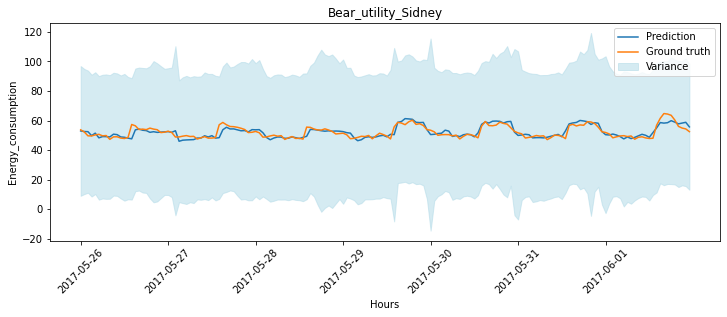

In [15]:
plot_predictions_against_original(buildingNames[0], transformed_means[0], transformed_var[0], transformed_orig[0])

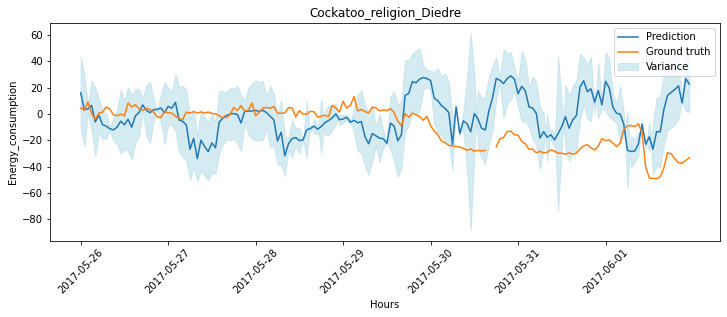

In [16]:
plot_predictions_against_original(buildingNames[1], transformed_means[1], transformed_var[1], transformed_orig[1])

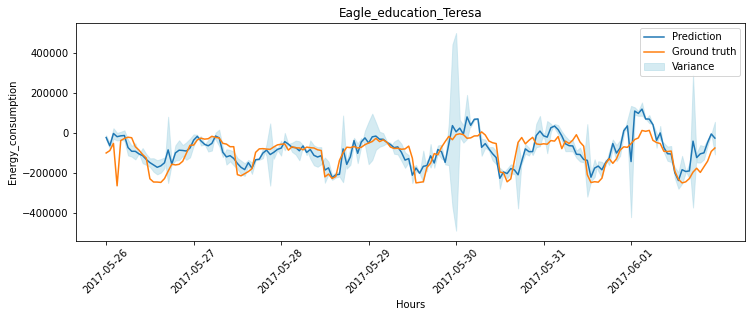

In [17]:
plot_predictions_against_original(buildingNames[3], transformed_means[3], transformed_var[3], transformed_orig[3])

### Plot predictions output directly from Gaussian Process Regression model

In [18]:
means = []
variances = []

for name in buildingNames: 
    mean, var = load_gpr_prediction_data(name)
    
    means.append(mean)
    variances.append(var)

### Load errors

In [19]:
rmses_week = []
maes_week = []


for name in buildingNames:
    rmse, mae = load_errors(name, 'week')
    rmses_week.append(rmse)
    maes_week.append(mae) 

### Plot weekly errors 

In [20]:
# Load weekly errors

rmses_week = []
maes_week = []


for name in buildingNames:
    rmse, mae = load_errors(name, 'week')
    rmses_week.append(rmse)
    maes_week.append(mae)

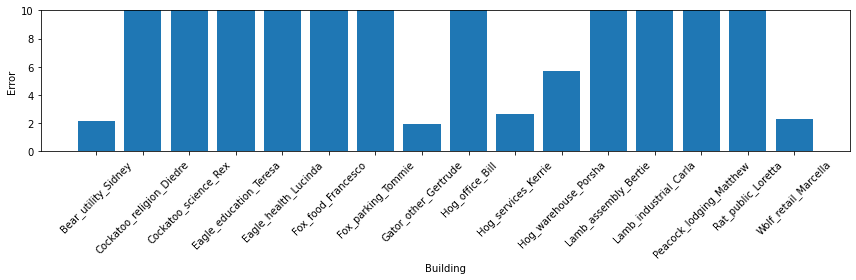

In [21]:
# Plot the errors in different y axis limits as the performance varies drastically

x = np.arange(len(buildingNames))

plt.figure(figsize=(12, 4))
plt.bar(x, rmses_week)

plt.xlabel('Building')
plt.ylabel('Error')

# Set the x-axis tick labels to be the building names
plt.xticks(x, buildingNames, rotation=45)
plt.ylim(0, 10)

plt.tight_layout()
plt.show()

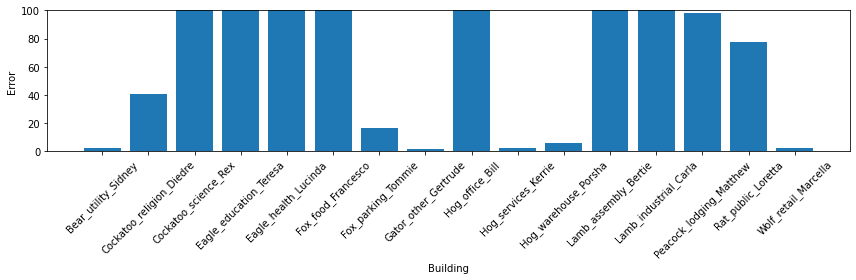

In [22]:
# Plot the errors in different y axis limits as the performance varies drastically

x = np.arange(len(buildingNames))

plt.figure(figsize=(12, 4))
plt.bar(x, rmses_week)

plt.xlabel('Building')
plt.ylabel('Error')

# Set the x-axis tick labels to be the building names
plt.xticks(x, buildingNames, rotation=45)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

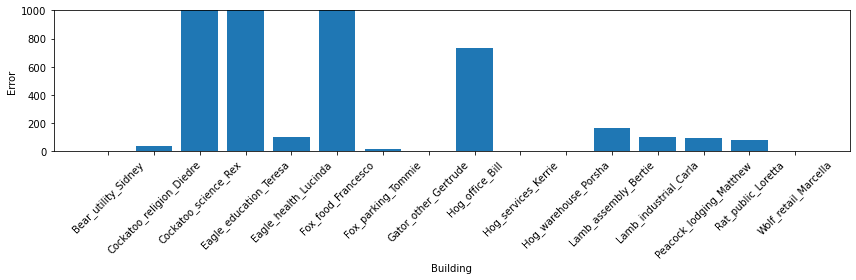

In [23]:
# Plot the errors in different y axis limits as the performance varies drastically

x = np.arange(len(buildingNames))

plt.figure(figsize=(12, 4))
plt.bar(x, rmses_week)

plt.xlabel('Building')
plt.ylabel('Error')

# Set the x-axis tick labels to be the building names
plt.xticks(x, buildingNames, rotation=45)
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()

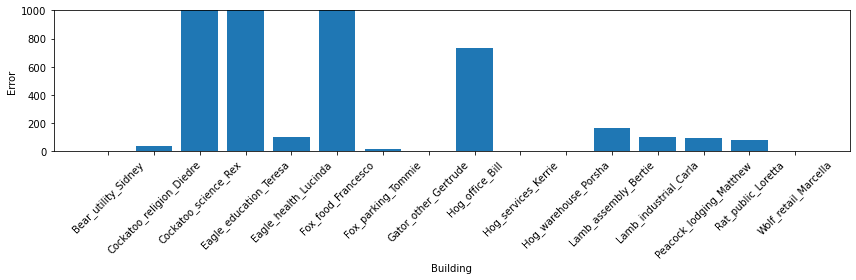

In [24]:
# Plot the errors in different y axis limits as the performance varies drastically

x = np.arange(len(buildingNames))

plt.figure(figsize=(12, 4))
plt.bar(x, rmses_week)

plt.xlabel('Building')
plt.ylabel('Error')

# Set the x-axis tick labels to be the building names
plt.xticks(x, buildingNames, rotation=45)
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()

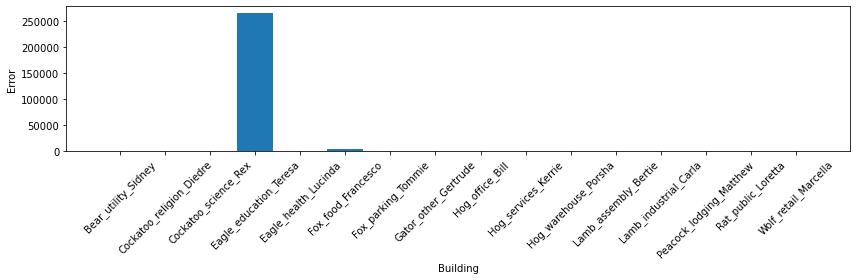

In [25]:
# Plot the errors in different y axis limits as the performance varies drastically

x = np.arange(len(buildingNames))

plt.figure(figsize=(12, 4))
plt.bar(x, rmses_week)

plt.xlabel('Building')
plt.ylabel('Error')

# Set the x-axis tick labels to be the building names
plt.xticks(x, buildingNames, rotation=45)

plt.tight_layout()
plt.show()

# <a name="comment_and_discussion"></a> 6 .Brief comment and discussion 
It is undoubted that the perfomance of this model is underwhelimg. <br>
For some of the buildings the approach yields good results e.g. Bear_utility_Sidney of Fox_parking_Tommie.
But it seems that for some buildings the model fails completely. 
This poor perfomance might come from the sampling before training the Gaussian Process Regeression model, as we train our model only on 2000 sample points, which is less than 84 days (less than 3 months) of data. Altough almost 17 months would be available for training. <br>
The problem why I had to sample the data before training, is that I was running into MemoryException errors when running the GPR on larger data. 


Another source of error is the handling of missing data. In case that the building has good data coverage during the training phase but a lot of missing data in the test phase, the input data to the model for prediction is bad, which will make the predictions faulty as well.

Also the transformation back into original datarang is a potential for errors. GPR assumes the data to be normal distributed, which is why we transform our data according to percentile of scores to follow gaussian distribution. When transforming back to our original electricity demand domain, there is some loss especially for peaks. Testing the transformation and retransformation on some dataframes already caused an rmse of > 1. I might need another concept for transforming the data to be normal distributed whil preserving the original data range


Nevertheless I need to investigate on individual buildings why the GPR models fail on predicting their energy demand